In [ ]:
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import numpy as np

# print(os.listdir("../input"))

import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', 100)

In [ ]:
import pandas as pd
lines = pd.read_csv('/content/banglish to bangla.csv')

In [ ]:
lines.head(20)

,Romanized_Text,Bangla_Text
0,onek din dekha hoy na,অনেক দিন দেখা হয় না
1,tomar naam ki?,তোমার নাম কী?
2,ajke amar jonmodin,আজকে আমার জন্মদিন
3,onek din dekha hoy na,অনেক দিন দেখা হয় না
4,tumi kemon acho?,তুমি কেমন আছো?
5,amake kichu jante hobe,আমাকে কিছু জানতে হবে
6,ami bhalo achi,আমি ভালো আছি
7,bhorer bela brishti chilo,ভোরের বেলা বৃষ্টি ছিলো
8,ami tomar shathe jabo,আমি তোমার সাথে যাবো
9,ami tomar shathe jabo,আমি তোমার সাথে যাবো


In [ ]:
lines.shape

(2000, 2)

In [ ]:
pd.isnull(lines).sum()

,0
Romanized_Text,0
Bangla_Text,0


In [ ]:
lines=lines[~pd.isnull(lines['Romanized_Text'])]

In [ ]:
# avoid redudancy
lines.drop_duplicates(inplace=True)

In [ ]:
lines=lines.sample(n=15,random_state=4500)
lines.shape

(15, 2)

In [ ]:
# Lowercase all characters
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: x.lower())
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: x.lower())

In [ ]:
# Remove quotes
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: re.sub("'", '', x))
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: re.sub("'", '', x))

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', string.digits)
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: x.translate(remove_digits))
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: x.translate(remove_digits))

lines['Bangla_Text'] = lines['Bangla_Text'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: x.strip())
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: x.strip())
lines['Romanized_Text']=lines['Romanized_Text'].apply(lambda x: re.sub(" +", " ", x))
lines['Bangla_Text']=lines['Bangla_Text'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences
lines['Bangla_Text'] = lines['Bangla_Text'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.head()

,Romanized_Text,Bangla_Text,length_banglish_sentence,length_bangla_sentence
13,khela suru hobe tay,START_ START খেলা শুরু হবে ৫টায় END _END,4,6
55,onek valo legeche,START_ START অনেক ভালো লেগেছে END _END,3,5
11,kothay jaccho,START_ START কোথায় যাচ্ছো END _END,2,4
2,ajke amar jonmodin,START_ START আজকে আমার জন্মদিন END _END,3,5
6,ami bhalo achi,START_ START আমি ভালো আছি END _END,3,5


In [ ]:
### Get Banglish and Bangla Vocabulary
all_eng_words=set()
for eng in lines['Romanized_Text']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_Bangla_words=set()
for hin in lines['Bangla_Text']:
    for word in hin.split():
        if word not in all_Bangla_words:
            all_Bangla_words.add(word)

# Add START_ and _END tokens to all_Bangla_words
all_Bangla_words.add('START_')
all_Bangla_words.add('_END')

In [ ]:
len(all_eng_words)

42

In [ ]:
len(all_Bangla_words)

44

In [ ]:
lines['length_banglish_sentence']=lines['Romanized_Text'].apply(lambda x:len(x.split(" ")))
lines['length_bangla_sentence']=lines['Bangla_Text'].apply(lambda x:len(x.split(" ")))

In [ ]:
lines.head()

,Romanized_Text,Bangla_Text,length_banglish_sentence,length_bangla_sentence
13,khela suru hobe tay,START_ START খেলা শুরু হবে ৫টায় END _END,4,8
55,onek valo legeche,START_ START অনেক ভালো লেগেছে END _END,3,7
11,kothay jaccho,START_ START কোথায় যাচ্ছো END _END,2,6
2,ajke amar jonmodin,START_ START আজকে আমার জন্মদিন END _END,3,7
6,ami bhalo achi,START_ START আমি ভালো আছি END _END,3,7


In [ ]:
lines[lines['length_banglish_sentence']>30].shape

(0, 4)

In [ ]:
lines=lines[lines['length_banglish_sentence']<=20]
lines=lines[lines['length_bangla_sentence']<=20]

In [ ]:
lines.shape

(15, 4)

In [ ]:
print("maximum length of Bangla Sentence ",max(lines['length_bangla_sentence']))
print("maximum length of Banglish Sentence ",max(lines['length_banglish_sentence']))

maximum length of Bangla Sentence  9
maximum length of Banglish Sentence  5


In [ ]:
max_length_src=max(lines['length_banglish_sentence'])
max_length_tar=max(lines['length_bangla_sentence'])

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_Bangla_words)) # Use the updated all_Bangla_words
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_Bangla_words) # Use the updated all_Bangla_words
num_encoder_tokens, num_decoder_tokens

(42, 44)

In [ ]:
num_decoder_tokens += 1 # Zero padding is handled by mask_zero=True in Embedding layer

In [ ]:
input_token_index = dict([(word, i) for i, word in enumerate(input_words)]) # Start indexing from 0
target_token_index = dict([(word, i) for i, word in enumerate(target_words)]) # Start indexing from 0

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

# Add a mapping for the out-of-vocabulary index if num_decoder_tokens is larger than the vocabulary size
if num_decoder_tokens > len(target_words):
    for i in range(len(target_words), num_decoder_tokens):
        reverse_target_char_index[i] = '<UNK>' # or some other placeholder token

In [ ]:
lines = shuffle(lines)
lines.head(10)

,Romanized_Text,Bangla_Text,length_banglish_sentence,length_bangla_sentence
6,ami bhalo achi,START_ START আমি ভালো আছি END _END,3,7
0,onek din dekha hoy na,START_ START অনেক দিন দেখা হয় না END _END,5,9
55,onek valo legeche,START_ START অনেক ভালো লেগেছে END _END,3,7
5,amake kichu jante hobe,START_ START আমাকে কিছু জানতে হবে END _END,4,8
1,tomar naam ki,START_ START তোমার নাম কী END _END,3,7
4,tumi kemon acho,START_ START তুমি কেমন আছো END _END,3,7
19,onek kaj ache,START_ START অনেক কাজ আছে END _END,3,7
11,kothay jaccho,START_ START কোথায় যাচ্ছো END _END,2,6
16,ekto opekkha koro,START_ START একটু অপেক্ষা করো END _END,3,7
13,khela suru hobe tay,START_ START খেলা শুরু হবে ৫টায় END _END,4,8


Split the data into train and test

In [ ]:
X, y = lines['Romanized_Text'], lines['Bangla_Text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=4200)
X_train.shape, X_test.shape

((10,), (5,))

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')#save data

In [ ]:
import numpy as np
import tensorflow as tf

def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='int32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='int32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    if word in input_token_index:
                      encoder_input_data[i, t] = input_token_index[word]  # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if word in target_token_index:
                      if t < len(target_text.split()) - 1:
                          decoder_input_data[i, t] = target_token_index[word]  # decoder input seq
                      if t > 0:
                          # decoder target sequence (one hot encoded)
                          # does not include the START_ token
                          # Offset by one timestep
                          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            # Reshape target data to remove the time dimension for categorical_crossentropy
            decoder_target_data = np.reshape(decoder_target_data, (batch_size * max_length_tar, num_decoder_tokens))
            yield ((tf.constant(encoder_input_data, dtype=tf.int32), tf.constant(decoder_input_data, dtype=tf.int32)), tf.constant(decoder_target_data, dtype=tf.float32))

In [ ]:
latent_dim=300 #encode decode

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = False) # Changed mask_zero to False
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 300) │     12,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 300) │     13,500 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 300),     │    721,200 │ embedding_2[0][0… │
│                     │ (None, 300),      │            │ not_equal_1[0][0] │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_3[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 45)  │     13,545 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,482,045 (5.65 MB)

 Trainable params: 1,482,045 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train.shape


(10,)

In [ ]:
X_test.shape

(5,)

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 8
epochs = 100

In [ ]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = 5)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 45), output.shape=(None, 9, 45)

<Axes: >

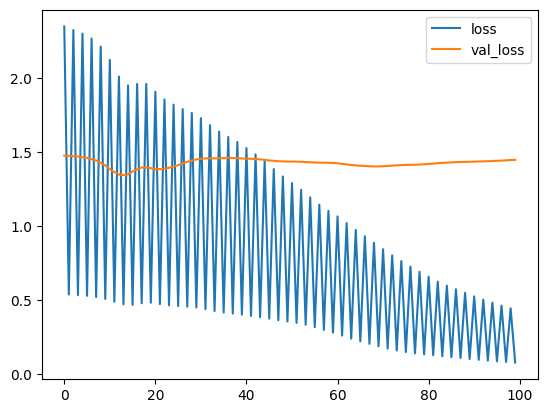

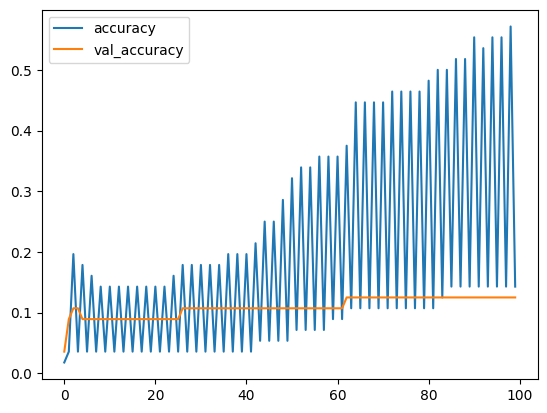

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [ ]:
model.save_weights('nmt_weights.weights.h5')

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))


    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']


    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
            # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
#         decoded_sentence += ' TEST TEST '+sampled_char


        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 100):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))

        target_seq[0, 0] = sampled_token_index
                # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Banglish sentence:', X_train[k:k+1].values[0])
print('Actual Bangla Translation:', y_train[k:k+1].values[0][6:-4])
print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Input Banglish sentence: khela suru hobe tay
Actual Bangla Translation:  START খেলা শুরু হবে ৫টায় END 
Human_Annotated_Bengali_Text Bangla Translation:  আজকে অনেক আমি সাথে সাথে যাবো কী সাথে কী ভালো অপেক্ষা অপেক্ষা অপেক্ষা অপেক্ষা দেখা শ

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Banglish sentence:', X_train[k:k+1].values[0])
print('Actual Bangla Translation:', y_train[k:k+1].values[0][6:-4])
print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Input Banglish sentence: onek din dekha hoy na
Actual Bangla Translation:  START অনেক দিন দেখা হয় না END 
Human_Annotated_Bengali_Text Bangla Translation:  যাবো লেগেছে আজ হবে হবে খেলা START সাথে সাথে ক

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Banglish sentence:', X_train[k:k+1].values[0])
print('Actual Bangla Translation:', y_train[k:k+1].values[0][6:-4])
print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


KeyError: np.int64(44)

In [ ]:
# Test Data

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Banglish sentence:', X_test[k:k+1].values[0])
print('Actual Bangla Translation:', y_test[k:k+1].values[0][6:-4])
print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Input Banglish sentence: onek kaj ache
Actual Bangla Translation:  START অনেক কাজ আছে END 
Human_Annotated_Bengali_Text Bangla

In [ ]:
# Test Data

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Banglish sentence:', X_test[k:k+1].values[0])
print('Actual Bangla Translation:', y_test[k:k+1].values[0][6:-4])
print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Test Data
test_gen = generate_batch(X_test, y_test, batch_size = 1)

for i in range(len(X_test)):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Banglish sentence:', X_test.iloc[i])
    print('Actual Bangla Translation:', y_test.iloc[i][6:-4])
    print('Human_Annotated_Bengali_Text Bangla Translation:', decoded_sentence[:-4])
    print('-' * 20) # Separator for clarity

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input Banglish sentence: ekto opekkha koro
Actual Bangla Translation:  START একটু অপেক্ষা করো END 
Human_Annotated_Bengali_Text Bangla Translation:  আজকে আজ END কিছু কিছু <UNK> <UNK> <UNK> 
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

In [ ]:
import numpy as np
import tensorflow as tf

def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='int32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='int32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    if word in input_token_index:
                      encoder_input_data[i, t] = input_token_index[word]  # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if word in target_token_index:
                      if t < len(target_text.split()) - 1:
                          decoder_input_data[i, t] = target_token_index[word]  # decoder input seq
                      if t > 0:
                          # decoder target sequence (one hot encoded)
                          # does not include the START_ token
                          # Offset by one timestep
                          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            # Reshape target data to remove the time dimension for categorical_crossentropy
            decoder_target_data = np.reshape(decoder_target_data, (batch_size * max_length_tar, num_decoder_tokens))
            yield ((tf.constant(encoder_input_data, dtype=tf.int32), tf.constant(decoder_input_data, dtype=tf.int32)), tf.constant(decoder_target_data, dtype=tf.float32))